<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_without_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                      

Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 5.0735 - accuracy: 0.8094
Epoch 1: val_accuracy improved from -inf to 0.84000, saving model to vgg19_glaucoma.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 14s 255ms/step - loss: 5.0735 - accuracy: 0.8094 - val_loss: 3.1915 - val_accuracy: 0.8400
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 2.0472 - accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.84000 to 0.88923, saving model to vgg19_glaucoma.h5
41/41 [==============================] - 10s 242ms/step - loss: 2.0472 - accuracy: 0.9252 - val_loss: 1.5966 - val_accuracy: 0.8892
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 1.1790 - accuracy: 0.9429
Epoch 3: val_accuracy improved from 0.88923 to 0.89231, saving model to vgg19_glaucoma.h5
41/41 [==============================] - 10s 248ms/step - loss: 1.1790 - accuracy: 0.9429 - val_loss: 1.2047 - val_accuracy: 0.8923
Epoch 4/100
41/41 [==============================] - ETA: 0s - loss: 0.9419 - accuracy: 0.9560
Epoch 4: val_accuracy did not improve from 0.89231
41/41 [==============================] - 9s 231ms/step - loss: 0.9419 - accuracy: 0.9560

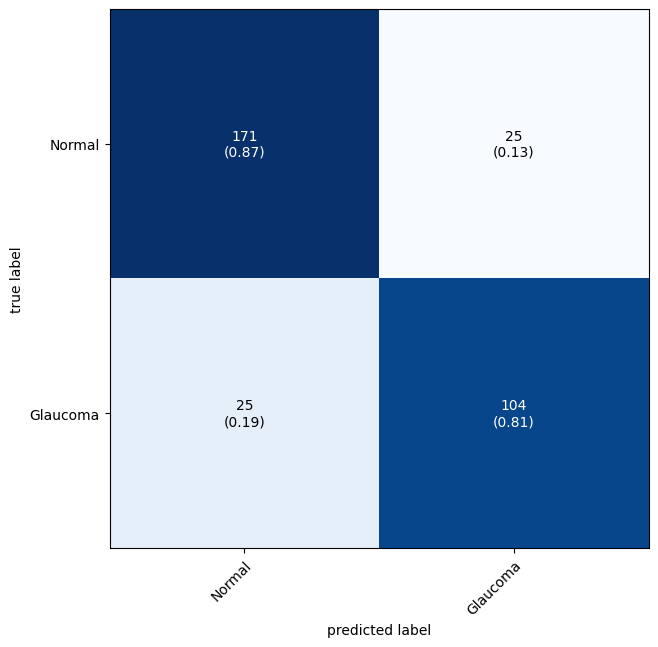

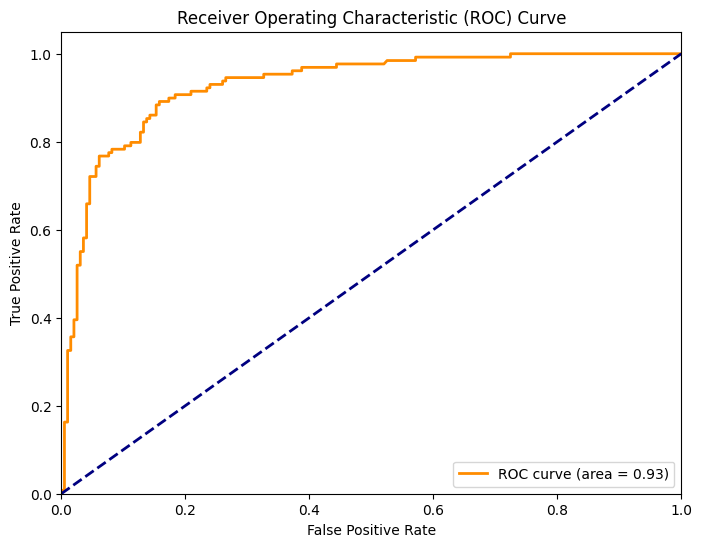

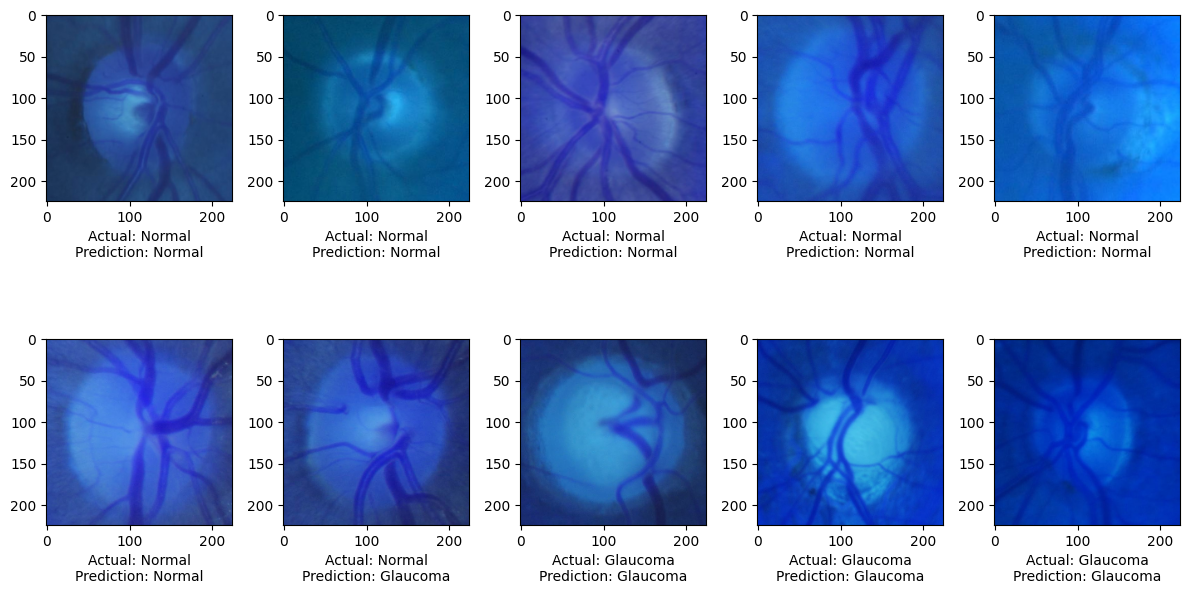

In [24]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import random

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            if img is not None:
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels)


# Path to your dataset folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'

# Load images from the folder
images, labels = load_images_from_folder(dataset_path)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("vgg19_glaucoma.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False, period=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test),
                    verbose=1, callbacks=[checkpoint, earlystop])

loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

y_pred = (model.predict(x_test) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

y_probs = model.predict(x_test).ravel()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Place this code after the ROC Curve plotting

plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Glaucoma"
    pred_label = "Normal" if pred_category == 0 else "Glaucoma"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {label}\nPrediction: {pred_label}")
plt.tight_layout()
plt.show()


In [4]:
# Save the model
model.save('/content/drive/MyDrive/glaucoma_classification_model.keras')

In [16]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/vgg19_glaucoma.h5')

# Path to the image to be predicted
image_path = '/content/drive/MyDrive/RIM-ONE_DL_images/partitioned_by_hospital/test_set/glaucoma/r1_Im135.png'

# Read and preprocess the image
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))
img = np.expand_dims(img, axis=0)
img = img / 255.0  # Normalize pixel values
img = np.array(img)

# Perform the prediction
predictions = model.predict(img)

# Determine the predicted class
predicted_class = 1 if predictions[0][0] > 0.5 else 0

# Display the predicted class
if predicted_class == 0:
    print("Predicted Class: 0 (Normal)")
else:
    print("Predicted Class: 1 (Glaucoma)")

1/1 [==============================] - 0s 252ms/step
Predicted Class: 0 (Normal)


In [22]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/vgg19_glaucoma.h5')

folder_path = '/content/drive/MyDrive/glaucoma_dataset/training/glaucoma'

class_0_count = 0
class_1_count = 0

for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)

    # Read and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Perform the prediction
    predictions = model.predict(img)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)

    # Update counters based on the predicted class
    if predicted_class == 0:
        class_0_count += 1
    else:
        class_1_count += 1

# Print the classification results
print(f"Class 0 Count: {class_0_count}")
print(f"Class 1 Count: {class_1_count}")

1/1 [==============================] - 0s 34ms/step
Class 0 Count: 662
Class 1 Count: 0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
